### **AGE AND GENDER PREDICTION USING DEEP LEARNING ⚙️**

#### KUSH OZA
#### D2 42
#### DL LAB PROJECT

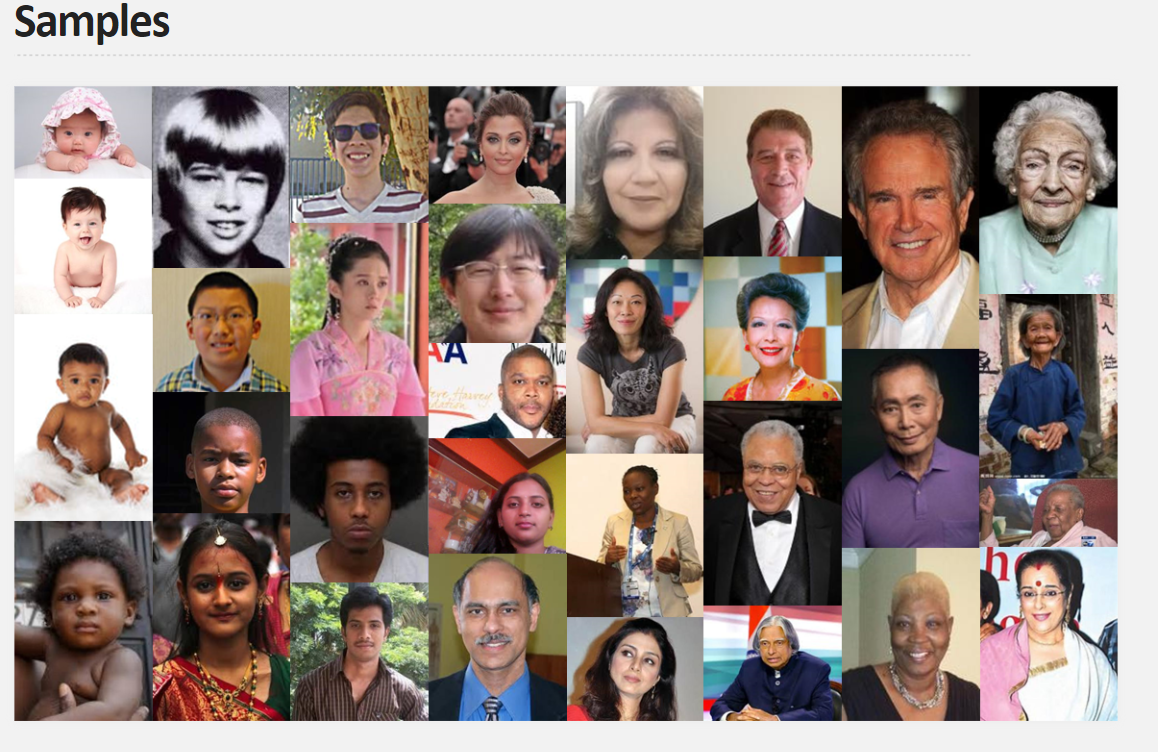

In [70]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

In [51]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 16
IMAGE_SIZE = 224

## EDA ON THE DATASET

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

In [62]:
# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path) / 255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

In [63]:
print("Total number of images:", len(image_paths))
print("Sample Image path:", rand_image_path)
print("Sample Age:", sample_age)
print("Sample Gender:", gender_mapping[int(sample_gender)])

Total number of images: 23708
Sample Image path: 31_1_1_20170112234534056.jpg.chip.jpg
Sample Age: 31
Sample Gender: Female


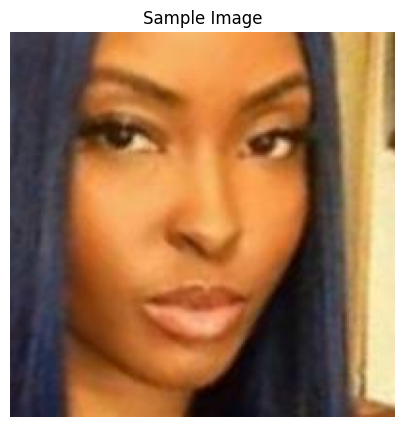

In [64]:
# Show the image
plt.figure(figsize=(5, 5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [65]:
# Initialize a male counter.
male_count = 0
ages = []

# Male counts
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Count total female counts
female_count = len(image_paths) - male_count

In [66]:
print(len(ages))

23708


In [67]:
import seaborn as sns

/tmp/ipykernel_34/2794015913.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Density'>

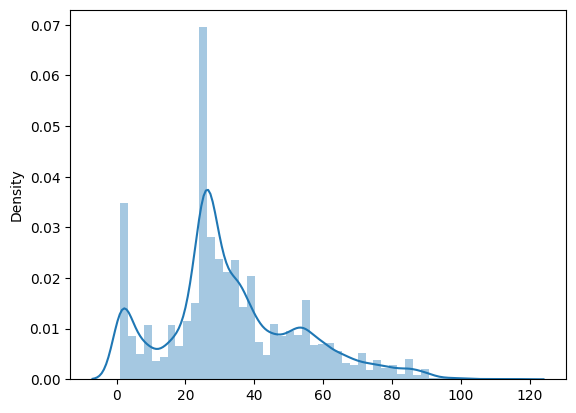

In [69]:
sns.distplot(ages)

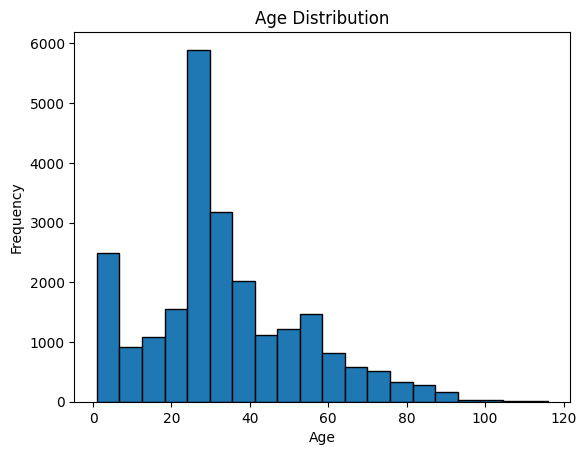

In [13]:
# Histogram of age
plt.hist(ages, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [14]:
import plotly.express as px
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    title = "Gender Distribution Donut Chart",
    height = 500
)
pie_chart.show()

In [16]:
print(f"Training Size : {len(valid_images)}")

Training Size : 2371


In [17]:
print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

Training Size : 21337
Testing Size  : 2371


In [18]:
# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

In [19]:
valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

In [20]:
test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

In [21]:
def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255
    image = tf.cast(image, tf.float32)

    return image, gender

In [22]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [23]:
valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [24]:
test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

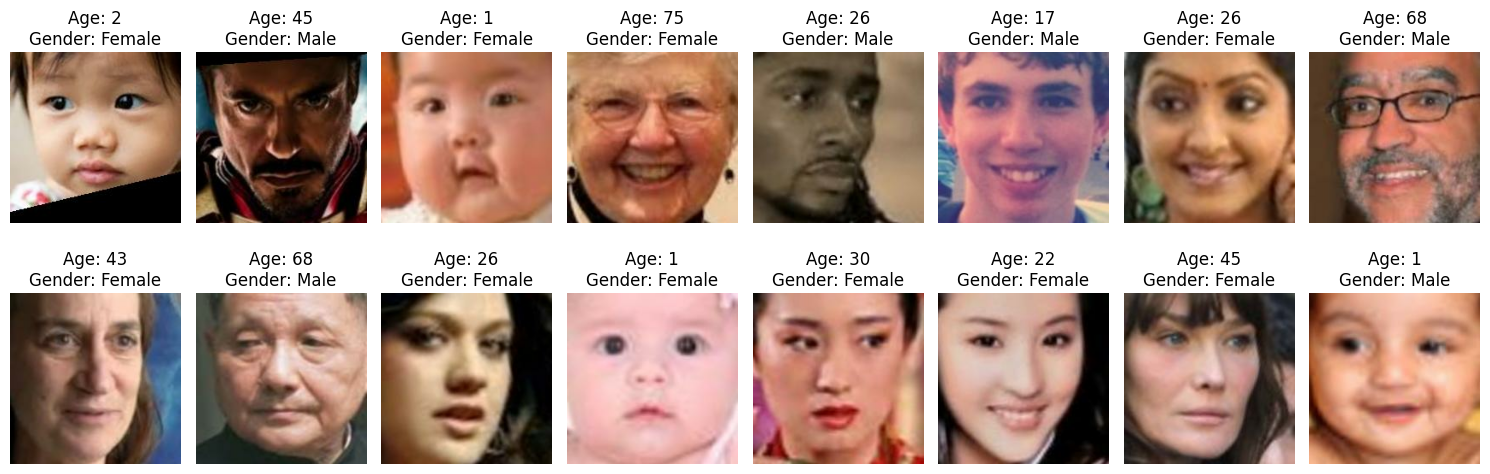

In [25]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

## VGG NETWORK FOR GENDER DETECTION

In [30]:
# Model
from keras.applications import VGG16

# Model training
from keras import Sequential
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer
from tensorflow.keras import layers

In [31]:
# Loading backbone
vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")

In [33]:
# Freeze the Model weights
vgg_16.trainable = False

# Creating a base model
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer"),
    vgg_16,
    layers.Dropout(0.2, name="SlightDropout"),
    layers.Flatten(name="FlattenEmbeddings"),
    layers.Dense(1, activation='sigmoid', name="gender")  # Sigmoid activation for binary classification
])

In [34]:
model.compile(
    loss="binary_crossentropy",  
    optimizer="adam",
    metrics=["accuracy"]
)

In [35]:
history = model.fit(
    train_gender_ds,
    validation_data=valid_gender_ds,
    epochs=20,
    batch_size=BATCH_SIZE
)

Epoch 1/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 101s 74ms/step - accuracy: 0.7898 - loss: 0.4542 - val_accuracy: 0.8705 - val_loss: 0.2892
Epoch 2/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 96s 72ms/step - accuracy: 0.8784 - loss: 0.2946 - val_accuracy: 0.8490 - val_loss: 0.3593
Epoch 3/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 96s 72ms/step - accuracy: 0.8928 - loss: 0.2647 - val_accuracy: 0.8853 - val_loss: 0.2724
Epoch 4/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 96s 72ms/step - accuracy: 0.8979 - loss: 0.2590 - val_accuracy: 0.8954 - val_loss: 0.2519
Epoch 5/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 96s 72ms/step - accuracy: 0.9074 - loss: 0.2321 - val_accuracy: 0.8996 - val_loss: 0.2433
Epoch 6/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 96s 72ms/step - accuracy: 0.9118 - loss: 0.2220 - val_accuracy: 0.8950 - val_loss: 0.2588
Epoch 7/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 97s 73ms/step - accuracy: 0.9134 - loss: 0.2125 - val_accuracy: 0.8912 - val_loss: 0.2835
Epoch 8/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 96s 72ms/step - accuracy: 0.9163 

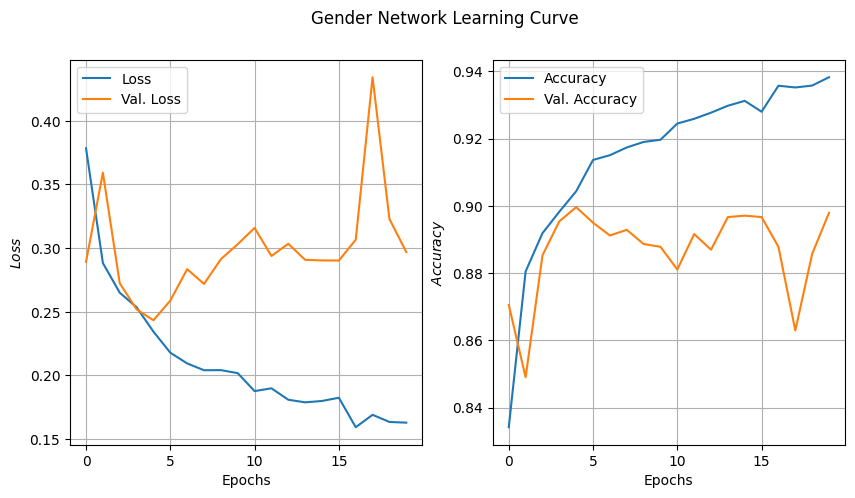

In [41]:
# Converting history into data frame.
gender_his_df = pd.DataFrame(history.history)

# Visualization
plt.figure(figsize=(10, 5 ))
plt.subplot(1,2,1)
plt.suptitle("Gender Network Learning Curve")
plt.plot(gender_his_df['loss'], label="Loss")
plt.plot(gender_his_df['val_loss'], label="Val. Loss")
plt.xlabel("Epochs")
plt.ylabel("$Loss$")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(gender_his_df['accuracy'], label="Accuracy")
plt.plot(gender_his_df['val_accuracy'], label="Val. Accuracy")
plt.xlabel("Epochs")
plt.ylabel("$Accuracy$")
plt.grid()
plt.legend()

plt.show()

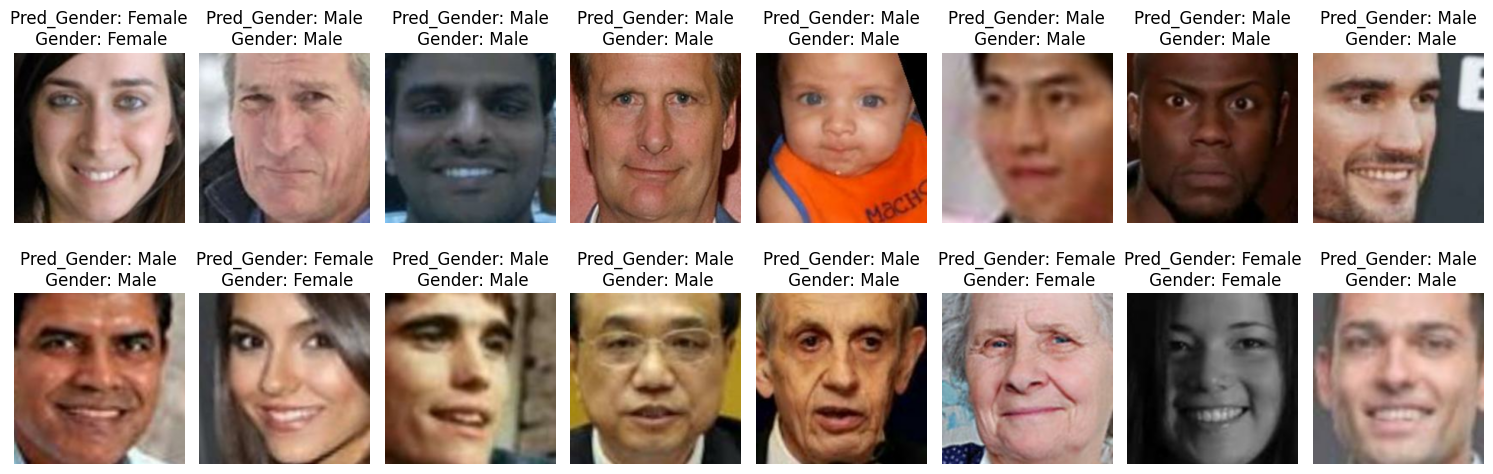

In [45]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(4):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        
        # Predictions
        pred_gender = tf.round(tf.squeeze(model.predict(image, verbose=0)))

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Pred_Gender: {gender_mapping[int(pred_gender)]}\n Gender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()